In [61]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime
import os
os.chdir("/home/agastya/data")
%matplotlib inline

In [96]:
train = pd.read_csv('/home/agastya/data/DataSets_Q1/TrainData.csv')
test = pd.read_csv('/home/agastya/data/DataSets_Q1/TestData.csv')

In [97]:
test.shape

(82748, 9)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import Series
X = train[['TimeStamp', 'nLastTradedPrice']]
X['TimeStamp'] = pd.to_datetime(X['TimeStamp'])
X = X[['TimeStamp', 'nLastTradedPrice']]
X.to_csv('data_stock.csv', index=False)
X = Series.from_csv('data_stock.csv', header=0)
X = X.astype('float32')
model = ARIMA(X, order=(50, 1, 0))
model_fit = model.fit(disp=False)
forecast = model_fit.forecast(steps = 82748)

/home/agastya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [ ]:
test1 = pd.DataFrame({'nLastTradedPrice': list(forecast[0])})
test1.to_csv('submission2.csv', index = False)

In [7]:
train['sSymbol'].value_counts()
#sSymbol variable is redundant

XYZ Corporation    16599
Name: sSymbol, dtype: int64

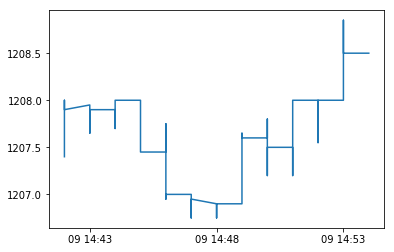

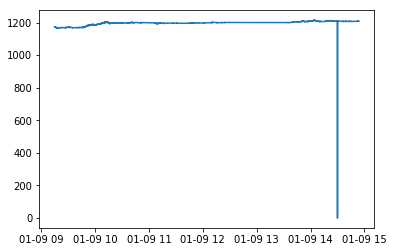

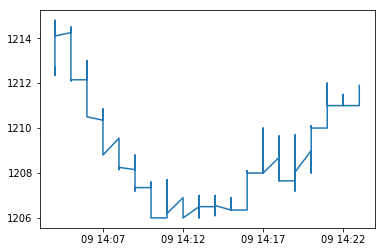

In [5]:
plt.plot(pd.to_datetime(train['TimeStamp'].iloc[16000:]), train['nBestSellOrderPrice'].iloc[16000:])
plt.show()
plt.plot(pd.to_datetime(train['TimeStamp']), train['nBestBuyOrderPrice'])
plt.show()
plt.plot(pd.to_datetime(train['TimeStamp'].iloc[14000:15000]), train['nLastTradedPrice'].iloc[14000:15000])
plt.show()

In [8]:
train1 = train.drop(['nSerialNumber', 'sSymbol', 'TimeStamp'], axis=1)
train1 = train1.values

In [9]:
##Simple MLP
##Train and test split
n = train1.shape[0]
p = train1.shape[1]
#train_start = 0
#train_end = int(np.floor(0.8*n))
#test_start = train_end + 1
#test_end = n
#data_train = train1[np.arange(train_start, train_end), :]
#data_test = train1[np.arange(test_start, test_end), :]
data_train = train1
data_test = train1

In [10]:
# Build X and y
tf.reset_default_graph()
X_train = data_train[:, [0,1,2,3,5]]
y_train = data_train[:, 4]
X_test = data_test[:, [0,1,2,3,5]]
y_test = data_test[:, 4]

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler_train = MinMaxScaler().fit(X_train)
X_train = scaler_train.transform(X_train)
X_test = scaler_train.transform(X_test)

In [12]:
#Defining placeholders
X = tf.placeholder(tf.float32, shape=[None, 5])
Y = tf.placeholder(tf.float32, shape=[None, 1])

In [13]:
#Model Architecture
#Layer 1
W1 = tf.get_variable(dtype=tf.float32, name='W1', shape=[5, 100],
                     initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.get_variable(dtype=tf.float32, name='b1', shape=[1, 100],
                     initializer=tf.zeros_initializer())
W2 = tf.get_variable(dtype=tf.float32, name='W2', shape=[100, 60],
                     initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.get_variable(dtype=tf.float32, name='b2', shape=[1, 60],
                     initializer=tf.zeros_initializer())
W3 = tf.get_variable(dtype=tf.float32, name='W3', shape=[60, 30],
                     initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.get_variable(dtype=tf.float32, name='b3', shape=[1, 30],
                     initializer=tf.zeros_initializer())
W4 = tf.get_variable(dtype=tf.float32, name='W4', shape=[30, 1],
                     initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.get_variable(dtype=tf.float32, name='b4', shape=[1, 1],
                     initializer=tf.zeros_initializer())

In [14]:
Z1 = tf.add(tf.matmul(X, W1), b1, name='Z1')
A1 = tf.nn.relu(Z1, name = 'A1')
Z2 = tf.add(tf.matmul(A1, W2), b2, name='Z2')
A2 = tf.nn.relu(Z2, name = 'A2')
Z3 = tf.add(tf.matmul(A2, W3), b3, name='Z3')
A3 = tf.nn.relu(Z3, name = 'A3')
Z4 = tf.add(tf.matmul(A3, W4), b4, name='Z4')

In [15]:
logits = tf.transpose(Z4)
cost = tf.reduce_mean(tf.squared_difference(Z4, Y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.00008).minimize(cost)
init = tf.global_variables_initializer()

In [16]:
test = test.drop(['nSerialNumber', 'TimeStamp', 'sSymbol', 'nLastTradedPrice'], axis=1)
test1 = scaler_train.transform(test)
test1.shape

(82748, 5)

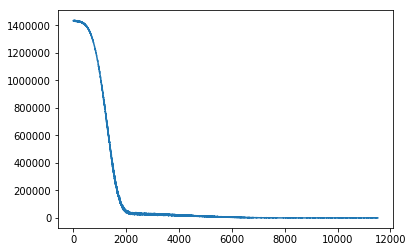

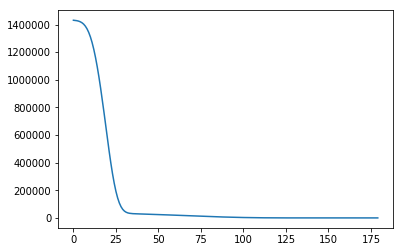

In [17]:
# Make Session
tf.set_random_seed(42)
np.random.seed(42)
net = tf.Session()
# Run initializer
net.run(tf.global_variables_initializer())

# Setup interactive plot
'''plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(111)
line1, = ax1.plot(y_test)
line2, = ax1.plot(y_test*0.5)
plt.show()'''

# Number of epochs and batch size
epochs = 180
batch_size = 256
training_costs = []
test_costs = []
for e in range(epochs):

    # Shuffle training data
    shuffle_indices = np.random.permutation(np.arange(len(y_train)))
    X_train = X_train[shuffle_indices]
    y_train = y_train[shuffle_indices]

    # Minibatch training
    for i in range(0, len(y_train) // batch_size):
        start = i * batch_size
        ytrain = y_train.reshape(-1, 1)
        batch_x = X_train[start:start + batch_size]
        batch_y = y_train[start:start + batch_size]
        batch_y = batch_y.reshape(-1, 1)
        # Run optimizer with batch
        _, training_cost = net.run([optimizer, cost], feed_dict={X: batch_x, Y: batch_y})
        training_costs.append(training_cost)
        # Show progress
    '''pred = net.run(logits, feed_dict={X: X_test})
    plt.ion()
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    line1, = ax1.plot(y_test)
    line2, = ax1.plot(pred.reshape(-1,1))
    plt.title('Epoch ' + str(e) + ', Batch ' + str(i))
    plt.show()'''
# Print final MSE after Training
    y_test = y_test.reshape(-1,1)
    mse_test = net.run(cost, feed_dict={X: X_test, Y: y_test})
    test_costs.append(mse_test)
plt.plot(training_costs)
plt.show()
pred_final = net.run(Z4, feed_dict={X: test1})
plt.plot(test_costs)
plt.show()

In [19]:
test_costs

[1431964.8,
 1431470.1,
 1430721.4,
 1429534.1,
 1427627.0,
 1424353.4,
 1419153.2,
 1411326.8,
 1400090.9,
 1384608.0,
 1364199.6,
 1337903.0,
 1305138.1,
 1265585.4,
 1219037.2,
 1165384.8,
 1104807.2,
 1037643.9,
 964634.31,
 886717.0,
 805132.38,
 721198.06,
 636577.88,
 553024.38,
 472265.97,
 395913.84,
 325464.0,
 262437.91,
 207739.78,
 161822.84,
 124651.83,
 95699.25,
 74025.898,
 58480.957,
 47856.551,
 40800.785,
 36321.754,
 33543.938,
 31837.938,
 30775.645,
 30080.703,
 29584.225,
 29190.24,
 28844.211,
 28519.795,
 28203.1,
 27890.541,
 27569.811,
 27236.805,
 26878.752,
 26526.916,
 26169.859,
 25809.469,
 25443.117,
 25072.68,
 24696.299,
 24317.211,
 23933.873,
 23542.42,
 23150.023,
 22752.318,
 22352.381,
 21949.154,
 21538.264,
 21125.582,
 20709.787,
 20291.715,
 19869.838,
 19439.062,
 19010.889,
 18580.0,
 18148.172,
 17713.4,
 17274.346,
 16837.643,
 16396.996,
 15956.956,
 15513.9,
 15072.937,
 14629.265,
 14187.87,
 13747.296,
 13306.446,
 12869.486,
 12432.

In [20]:
pred_final

array([[ 1207.90490723],
       [ 1207.90490723],
       [ 1207.89880371],
       ..., 
       [ 2175.36083984],
       [ 2175.36083984],
       [ 2175.36083984]], dtype=float32)

In [76]:
test1 = pd.DataFrame({'nLastTradedPrice': list(test['nBestSellOrderPrice'] - 0.5)})
test1.to_csv('submission2.csv', index = False)

In [24]:
train['nLastTradedPrice'].value_counts()

1200.00    1327
1200.15     585
1196.00     360
1197.00     309
1200.10     291
1199.00     264
1200.05     261
1198.00     235
1208.00     189
1198.50     160
1200.50     153
1200.20     149
1211.00     134
1201.00     132
1196.50     132
1207.00     131
1210.00     124
1199.30     115
1199.05     109
1199.25     109
1200.45     107
1200.60     102
1200.40      99
1197.50      98
1196.55      93
1207.50      93
1199.35      90
1199.50      87
1195.50      85
1168.55      85
           ... 
1170.40       1
1191.45       1
1185.30       1
1204.75       1
1187.10       1
1185.05       1
1183.35       1
1204.25       1
1183.10       1
1180.55       1
1167.80       1
1180.80       1
1211.65       1
1186.60       1
1194.40       1
1185.20       1
1184.95       1
1174.65       1
1184.35       1
1177.10       1
1178.85       1
1187.70       1
1177.80       1
1177.05       1
1183.45       1
1178.35       1
1180.20       1
1187.20       1
1188.80       1
1190.35       1
Name: nLastTradedPrice, 

In [20]:
from subprocess import check_output
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.cross_validation import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from numpy import newaxis

/home/agastya/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [23]:
train.head()

,nSerialNumber,TimeStamp,sSymbol,nBestBuyOrderPrice,nBestBuyOrderQuantity,nBestSellOrderPrice,nBestSellOrderQuantity,nLastTradedPrice,nTotalTradedQuantity
0,1,01-09-2017 09:15,XYZ Corporation,1173.05,26,1174.20,335,1173.00,2850
1,2,01-09-2017 09:15,XYZ Corporation,1172.10,5,1172.95,21,1172.95,3049
2,3,01-09-2017 09:15,XYZ Corporation,1172.00,163,1172.10,6,1172.00,3112
3,4,01-09-2017 09:15,XYZ Corporation,1172.00,23,1172.90,26,1172.00,3384
4,5,01-09-2017 09:15,XYZ Corporation,1171.00,111,1171.05,9,1171.00,3579


In [33]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [26]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16599 entries, 0 to 16598
Data columns (total 9 columns):
nSerialNumber             16599 non-null int64
TimeStamp                 16599 non-null object
sSymbol                   16599 non-null object
nBestBuyOrderPrice        16599 non-null float64
nBestBuyOrderQuantity     16599 non-null int64
nBestSellOrderPrice       16599 non-null float64
nBestSellOrderQuantity    16599 non-null int64
nLastTradedPrice          16599 non-null float64
nTotalTradedQuantity      16599 non-null int64
dtypes: float64(3), int64(4), object(2)
memory usage: 1.1+ MB


In [28]:
train = train.drop(['nSerialNumber', 'sSymbol'], axis=1)
train = train[['nBestBuyOrderPrice', 'nBestBuyOrderQuantity', 'nBestSellOrderPrice',
               'nBestSellOrderQuantity', 'nTotalTradedQuantity', 'nLastTradedPrice']]

In [47]:
# load dataset
values = train.values
# integer encode direction
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[7, 8, 9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)  \
1   0.966070   0.006469   0.161156   0.044303   0.000124   0.143442  0.965287   
2   0.965287   0.001244   0.135328   0.002653   0.000248   0.142416  0.965205   
3   0.965205   0.040557   0.117767   0.000663   0.000372   0.122950  0.965205   
4   0.965205   0.005723   0.134296   0.003316   0.000496   0.122950  0.964381   
5   0.964381   0.027619   0.096075   0.001061   0.000620   0.102459  0.964381   

    var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  
1  0.001244  0.135328  0.002653  0.000248  0.142416  
2  0.040557  0.117767  0.000663  0.000372  0.122950  
3  0.005723  0.134296  0.003316  0.000496  0.122950  
4  0.027619  0.096075  0.001061  0.000620  0.102459  
5  0.004728  0.114668  0.003316  0.000743  0.102459  


In [51]:
final = np.array(MinMaxScaler().fit_transform(values[:,:4]))